In [1]:
import torch
import torch.nn as nn
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from PIL import Image
import torch.nn.functional as F
import torch.optim as optim
# import i2v
import numpy as np
import matplotlib.pyplot as plt

## 构造数据集

In [3]:
categories = ['disgust','fear','happy','surprise','sad','angry','neutral']
# label = 0,1,2,3,4,5,6

In [4]:
file_train = []
file_test = []
number_train = []
number_test = []

In [5]:
# categories.index('neutral')
# number_train.append(1)
# number_train

In [6]:
# category = 'neutral'
for category in categories:
    label = categories.index(category)
    for root,dirs,files in os.walk("..//detect_faces//"+str(category)): 
        for file in files:
            file_type = file.split('_')[1]
    #         print(file_type)
            # train_data
            if file_type == 'train':
                file_train.append(os.path.join(root,file))
                number_train.append(label)
            else:
                file_test.append(os.path.join(root,file))
                number_test.append(label)

In [7]:
print("trainset_size: "+ str(len(file_train)))
print("testset_size: "+ str(len(file_test)))

trainset_size: 32080
testset_size: 8016


In [8]:
class testset(Dataset):
    def __init__(self, transform=None):
        #定义好 image 的路径
        self.images = file_test
        self.target = number_test
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        image = Image.open(image)
        if self.transform:
            image = self.transform(image)
        target = self.target[index]
        return image,target

    def __len__(self):
        return len(self.images)

In [9]:
class trainset(Dataset):
    def __init__(self, transform=None):
        #定义好 image 的路径
        self.images = file_train
        self.target = number_train
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        image = Image.open(image)
        if self.transform:
            image = self.transform(image)
        target = self.target[index]
        return image,target

    def __len__(self):
        return len(self.images)

In [10]:
# 应用了torchvision.transforms.ToTensor，其作用是将数据归一化到[0,1]（是将数据除以255）
# [0.485, 0.456, 0.406]这一组平均值是从imagenet训练集中抽样算出来的。
# 数据如果分布在(0,1)之间，可能实际的bias，就是神经网络的输入b会比较大，
# 而模型初始化时b=0的，这样会导致神经网络收敛比较慢，经过Normalize后，可以加快模型的收敛速度。
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [11]:
train_dataset = trainset(transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True)
test_dataset = testset(transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64,shuffle=False)

## 模型搭建

In [12]:
class Net1(torch.nn.Module):
    def __init__(self):
        super(Net1,self).__init__()
        self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,padding=1)
        self.conv2 = torch.nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.conv3 = torch.nn.Conv2d(128,256,kernel_size=3,padding=1)
        self.pooling1 = torch.nn.MaxPool2d(2)
        self.pooling2 = torch.nn.MaxPool2d(4)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(4096,4096)
        self.fc2 = torch.nn.Linear(4096,4096)
        self.fc3 = torch.nn.Linear(4096,7)
    
    def forward(self,x):
        batch_size = x.size(0)
        x = self.pooling1(F.relu(self.conv1(x)))
        x = self.pooling2(F.relu(self.conv2(x)))
        x = self.pooling2(F.relu(self.conv3(x)))
        # flatten
        x = x.view(batch_size, -1)
        
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        return x

In [13]:
# class Net2(torch.nn.Module):
#     def __init__(self):
#         super(Net2,self).__init__()
#         self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,padding=1)
#         self.conv2 = torch.nn.Conv2d(64,128,kernel_size=3,padding=1)
#         self.conv3 = torch.nn.Conv2d(128,256,kernel_size=3,padding=1)
#         self.conv4 = torch.nn.Conv2d(256,256,kernel_size=3,padding=1)
#         self.pooling1 = torch.nn.MaxPool2d(2)
#         self.pooling2 = torch.nn.MaxPool2d(4)
#         self.fc1 = torch.nn.Linear(4096,4096)
#         self.fc2 = torch.nn.Linear(4096,4096)
#         self.fc3 = torch.nn.Linear(4096,7)
    
#     def forward(self,x):
#         batch_size = x.size(0)
#         x = self.pooling1(F.relu(self.conv1(x)))
#         x = self.pooling2(F.relu(self.conv2(x)))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = self.pooling2(x)
#         # flatten
#         x = x.view(batch_size, -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [14]:
# class Net3(torch.nn.Module):
#     def __init__(self):
#         super(Net3,self).__init__()
#         self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,padding=1)
#         self.conv2 = torch.nn.Conv2d(64,128,kernel_size=3,padding=1)
#         self.conv3 = torch.nn.Conv2d(128,128,kernel_size=3,padding=1)
#         self.conv4 = torch.nn.Conv2d(128,256,kernel_size=3,padding=1)
#         self.conv5 = torch.nn.Conv2d(256,256,kernel_size=3,padding=1)
#         self.pooling1 = torch.nn.MaxPool2d(2)
#         self.pooling2 = torch.nn.MaxPool2d(4)
#         self.fc1 = torch.nn.Linear(4096,4096)
#         self.fc2 = torch.nn.Linear(4096,4096)
#         self.fc3 = torch.nn.Linear(4096,7)
    
#     def forward(self,x):
#         batch_size = x.size(0)
#         x = self.pooling1(F.relu(self.conv1(x)))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = self.pooling2(x)
#         x = F.relu(self.conv4(x))
#         x = F.relu(self.conv5(x))
#         x = self.pooling2(x)
#         # flatten
#         x = x.view(batch_size, -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [15]:
# # Ensemble模型
# class Net1_mix(torch.nn.Module):
#     def __init__(self):
#         super(Net1,self).__init__()
#         self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,padding=1)
#         self.conv2 = torch.nn.Conv2d(64,128,kernel_size=3,padding=1)
#         self.conv3 = torch.nn.Conv2d(128,256,kernel_size=3,padding=1)
#         self.pooling1 = torch.nn.MaxPool2d(2)
#         self.pooling2 = torch.nn.MaxPool2d(4)
#         self.fc1 = torch.nn.Linear(4096,4096)
#         self.fc2 = torch.nn.Linear(4096,4096)
    
#     def forward(self,x):
#         batch_size = x.size(0)
#         x = self.pooling1(F.relu(self.conv1(x)))
#         x = self.pooling2(F.relu(self.conv2(x)))
#         x = self.pooling2(F.relu(self.conv3(x)))
#         # flatten
#         x = x.view(batch_size, -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         return x
# class Net2_mix(torch.nn.Module):
#     def __init__(self):
#         super(Net2,self).__init__()
#         self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,padding=1)
#         self.conv2 = torch.nn.Conv2d(64,128,kernel_size=3,padding=1)
#         self.conv3 = torch.nn.Conv2d(128,256,kernel_size=3,padding=1)
#         self.conv4 = torch.nn.Conv2d(256,256,kernel_size=3,padding=1)
#         self.pooling1 = torch.nn.MaxPool2d(2)
#         self.pooling2 = torch.nn.MaxPool2d(4)
#         self.fc1 = torch.nn.Linear(4096,4096)
#         self.fc2 = torch.nn.Linear(4096,4096)
    
#     def forward(self,x):
#         batch_size = x.size(0)
#         x = self.pooling1(F.relu(self.conv1(x)))
#         x = self.pooling2(F.relu(self.conv2(x)))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = self.pooling2(x)
#         # flatten
#         x = x.view(batch_size, -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         return x
# class Net3_mix(torch.nn.Module):
#     def __init__(self):
#         super(Net3,self).__init__()
#         self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,padding=1)
#         self.conv2 = torch.nn.Conv2d(64,128,kernel_size=3,padding=1)
#         self.conv3 = torch.nn.Conv2d(128,128,kernel_size=3,padding=1)
#         self.conv4 = torch.nn.Conv2d(128,256,kernel_size=3,padding=1)
#         self.conv5 = torch.nn.Conv2d(256,256,kernel_size=3,padding=1)
#         self.pooling1 = torch.nn.MaxPool2d(2)
#         self.pooling2 = torch.nn.MaxPool2d(4)
#         self.fc1 = torch.nn.Linear(4096,4096)
#         self.fc2 = torch.nn.Linear(4096,4096)
    
#     def forward(self,x):
#         batch_size = x.size(0)
#         x = self.pooling1(F.relu(self.conv1(x)))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = self.pooling2(x)
#         x = F.relu(self.conv4(x))
#         x = F.relu(self.conv5(x))
#         x = self.pooling2(x)
#         # flatten
#         x = x.view(batch_size, -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         return x
# # 声明网络
# model_net1 = Net1_mix()
# model_net2 = Net2_mix()
# model_net3 = Net3_mix()
# # 导入参数
# save_path = '..//Final-Project//model_save//'
# state_dict1 = torch.load(save_path+"Net1_epoch60.pth")
# state_dict2 = torch.load(save_path+"Net2_epoch60.pth")
# state_dict3 = torch.load(save_path+"Net3_epoch60.pth")

# keys = []
# for k,v in state_dict1.items():
#   #将‘fc3’开头的key过滤掉，这里是要去除的层的key
#     if k.startswith('fc3'):  
#         continue
#     keys.append(k)

# # 去除指定层后的模型
# state_dict1 = {k:state_dict1[k] for k in keys}

# keys = []
# for k,v in state_dict2.items():
#   #将‘fc3’开头的key过滤掉，这里是要去除的层的key
#     if k.startswith('fc3'):  
#         continue
#     keys.append(k)
# # 去除指定层后的模型
# state_dict2 = {k:state_dict1[k] for k in keys}

# keys = []
# for k,v in state_dict2.items():
#   #将‘fc3’开头的key过滤掉，这里是要去除的层的key
#     if k.startswith('fc3'):  
#         continue
#     keys.append(k)

# # 去除指定层后的模型
# state_dict3 = {k:state_dict1[k] for k in keys}

# #自己定义的模型，但要保证前面保存的层和自定义的模型中的层一致
# model_net1.load_state_dict(state_dict1)
# model_net2.load_state_dict(state_dict2)
# model_net3.load_state_dict(state_dict3)

# class NetMix(torch.nn.Module):
#     def __init__(self):
#         super(NetMix,self).__init__()
#         self.net1 = model_net1
#         self.net2 = model_net2
#         self.net3 = model_net3
#         for p in self.parameters():
#             p.requires_grad = False #预训练模型加载进来后全部设置为不更新参数，然后再后面加层
#         self.fc = torch.nn.Linear(4096*3,7)
    
#     def forward(self,x):
#         batch_size = x.size(0)
#         x1 = net1(x)
#         x2 = net2(x)
#         x3 = net3(x)
#         # 拼接输入
#         x = torch.cat((x1,x2,x3),dim = 1)
#         # 输出
#         x = self.fc(x)
#         return x

## 模型配置

### Net1配置

In [16]:
model = Net1()

### Net2配置

In [17]:
# model = Net2()

### Net3配置

In [18]:
# model = Net3()

### Net1+2+3配置

In [19]:
# model = NetMix()

### 共同配置

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
device

device(type='cuda', index=0)

In [22]:
model.to(device)

Net1(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pooling2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=7, bias=True)
)

In [22]:
# 损失、优化函数定义
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)

# 带冲量的优化，冲量为0.5
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [23]:
# result = []
# one_hot = [0,0,0,0,0,0,0]
# one_hot[1] = 1
# result.append(one_hot)
# result.append(one_hot)
# torch.Tensor(result)

In [24]:
def get_one_hot(labels):
    result = []
    # batch_size=64
    size = len(labels)
    for i in range(size):
        one_hot = [0,0,0,0,0,0,0]
        one_hot[labels[i]] = 1
        result.append(one_hot)
    return torch.Tensor(result)

In [25]:
def train(epoch):
    running_loss = 0.0
    total = 0
    correct = 0
    for batch_idx,data in enumerate(train_loader,0):
        # 开启训练阶段
        model.train()
        inputs, target = data
        # 转换为one-hot向量
        target_one_hot = get_one_hot(target)
        # 将用来计算的张量迁移到GPU
        inputs, target_one_hot = inputs.to(device), target_one_hot.to(device)
        
        # 初始化优化器
        optimizer.zero_grad()
        
        # forward+backward+update
        outputs = model(inputs)
        
        with torch.no_grad():
            # 开启测试阶段
            model.eval()
            target = target.to(device)
            # 沿着第一个维度取最大值的下标，返回最大值、最大值下标
            _, predicted = torch.max(outputs.data, dim=1)
            total += target.size(0)
            # 计算训练集准确率
            correct += (predicted == target).sum().item()
        # 开启训练阶段
        model.train()
        loss = criterion(outputs, target_one_hot)
        # 将用来计算的张量迁移到GPU
        loss = loss.to(device)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if batch_idx % 500 == 499:
            # 以500个patch的平均loss作为此epoch的loss(loss/patch)
            train_loss_list.append(running_loss / 500)
            print('[%d, %5d] loss: %.3f' % (epoch + 1,batch_idx + 1, running_loss / 500))
            running_loss = 0.0
            # 以500个patch中所有数据的平均accuracy作为此epoch的accuracy(accuracy/data)
            train_accuracy_list.append(100 * correct/total)
            print('Accuracy on train set: %d %% [%d/%d]' % (100 * correct/total,correct,total))
            correct = 0
            total = 0

In [26]:
def test():
    correct = 0
    total = 0
    error = 0
    with torch.no_grad():
        # 开启测试阶段
        model.eval()
        for data in test_loader:
            images, labels = data

            # 将用来计算的张量迁移到GPU
            images, labels = images.to(device), labels.to(device)
            # 用于计算测试集损失
            one_hot_labels = get_one_hot(labels)
            one_hot_labels = one_hot_labels.to(device)
            
            outputs = model(images)
            
            # 计算测试集损失
            error += F.cross_entropy(outputs,one_hot_labels).sum().item()
            
            # 沿着第一个维度取最大值的下标，返回最大值、最大值下标
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            # 计算测试集准确率
            correct += (predicted == labels).sum().item()
            
        test_accuracy_list.append(100 * correct/total)
        test_loss_list.append(error / total)
        print('Accuracy on test set: %d %% [%d/%d]' % (100 * correct/total,correct,total))

## 训练

In [27]:
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

In [28]:
# 作图（100epochs）
def plot_loss():
    # 1.创建画布
#     plt.figure(figsize=(10,8),dpi=100)
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8),dpi=100)

    # 2.绘制图像
    epochs = np.linspace(1,100,100)
#     train_loss = epochs
#     test_loss = epochs + 10
#     train_accuracy = epochs + 10
#     test_accuracy = epochs
    axes[0].set_xlabel("epoch")
    axes[0].set_ylabel("loss(CE)/patch")
    axes[0].set_title("loss", fontsize=10)
    axes[0].plot(epochs, train_loss_list, color = 'r',label="train_loss")
    axes[0].plot(epochs, test_loss_list, color = 'b',label="test_loss")
    axes[0].legend(loc="best")
    
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy(%)")
    axes[1].set_title("accuracy", fontsize=10)
    axes[1].plot(epochs, train_accuracy_list, color = 'r',label="train_accuracy")
    axes[1].plot(epochs, test_accuracy_list, color = 'b',label="test_accuracy")
    axes[1].legend(loc="best")
    
    plt.show()     #显示图片

In [4]:
# 作图（n epochs）
def plot_loss_n(n):
    # 1.创建画布
#     plt.figure(figsize=(10,8),dpi=100)
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8),dpi=100)

    # 2.绘制图像
    epochs = np.linspace(1,n,n)
#     train_loss = epochs
#     test_loss = epochs + 10
#     train_accuracy = epochs + 10
#     test_accuracy = epochs
    axes[0].set_xlabel("epoch")
    axes[0].set_ylabel("loss(CE)/patch")
    axes[0].set_title("loss", fontsize=10)
    axes[0].plot(epochs, train_loss_list[:n], color = 'r',label="train_loss")
    axes[0].plot(epochs, test_loss_list[:n], color = 'b',label="test_loss")
    axes[0].legend(loc="best")
    
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy(%)")
    axes[1].set_title("accuracy", fontsize=10)
    axes[1].plot(epochs, train_accuracy_list[:n], color = 'r',label="train_accuracy")
    axes[1].plot(epochs, test_accuracy_list[:n], color = 'b',label="test_accuracy")
    axes[1].legend(loc="best")
    
    plt.show()     #显示图片

In [30]:
if __name__ == '__main__':
    save_path = '..//Final-Project//model_save//'
    for epoch in range(100):
        train(epoch)
        test()
        # 2个epoch保存一次模型
        if epoch % 2 == 1:
            torch.save(model.state_dict(), save_path+"Net1_drop_epoch"+ str(epoch+1)+ '.pth')

[1,   500] loss: 1.615
Accuracy on train set: 34 % [10896/32000]
Accuracy on test set: 45 % [3666/8016]
[2,   500] loss: 1.288
Accuracy on train set: 47 % [15166/32000]
Accuracy on test set: 49 % [3957/8016]
[3,   500] loss: 1.183
Accuracy on train set: 52 % [16660/32000]
Accuracy on test set: 50 % [4069/8016]
[4,   500] loss: 1.115
Accuracy on train set: 54 % [17405/32000]
Accuracy on test set: 50 % [4068/8016]
[5,   500] loss: 1.066
Accuracy on train set: 57 % [18240/32000]
Accuracy on test set: 53 % [4277/8016]
[6,   500] loss: 1.021
Accuracy on train set: 58 % [18759/32000]
Accuracy on test set: 55 % [4458/8016]
[7,   500] loss: 0.987
Accuracy on train set: 60 % [19336/32000]
Accuracy on test set: 57 % [4607/8016]
[8,   500] loss: 0.945
Accuracy on train set: 62 % [19856/32000]
Accuracy on test set: 57 % [4592/8016]
[9,   500] loss: 0.912
Accuracy on train set: 63 % [20397/32000]
Accuracy on test set: 56 % [4550/8016]
[10,   500] loss: 0.880
Accuracy on train set: 64 % [20793/32000

KeyboardInterrupt: 

In [31]:
# # 换算为每个patch的loss
test_loss_list_patch = [i * 64 for i in test_loss_list]
test_loss_list = test_loss_list_patch

## 保存与加载

In [33]:
len(train_accuracy_list[:50])

50

In [34]:
# # 保存loss与accuracy
# train_loss_list = np.array(train_loss_list)
# test_loss_list = np.array(test_loss_list)
# train_accuracy_list = np.array(train_accuracy_list)
# test_accuracy_list = np.array(test_accuracy_list)
# np.savetxt("..//Final-Project//log_save//Net1_drop_train_loss_list.txt",train_loss_list)
# np.savetxt("..//Final-Project//log_save//Net1_drop_test_loss_list.txt",test_loss_list)
# np.savetxt("..//Final-Project//log_save//Net1_drop_train_accuracy_list.txt",train_accuracy_list)
# np.savetxt("..//Final-Project//log_save//Net1_drop_test_accuracy_list.txt",test_accuracy_list)

In [32]:
save_path = '..//Final-Project//model_save//'
state_dict = torch.load(save_path+"Net1_drop_epoch10.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [33]:
train_loss_list = np.loadtxt("..//Final-Project//log_save//Net1_drop_train_loss_list.txt")
test_loss_list = np.loadtxt("..//Final-Project//log_save//Net1_drop_test_loss_list.txt")
train_accuracy_list = np.loadtxt("..//Final-Project//log_save//Net1_drop_train_accuracy_list.txt")
test_accuracy_list = np.loadtxt("..//Final-Project//log_save//Net1_drop_test_accuracy_list.txt")

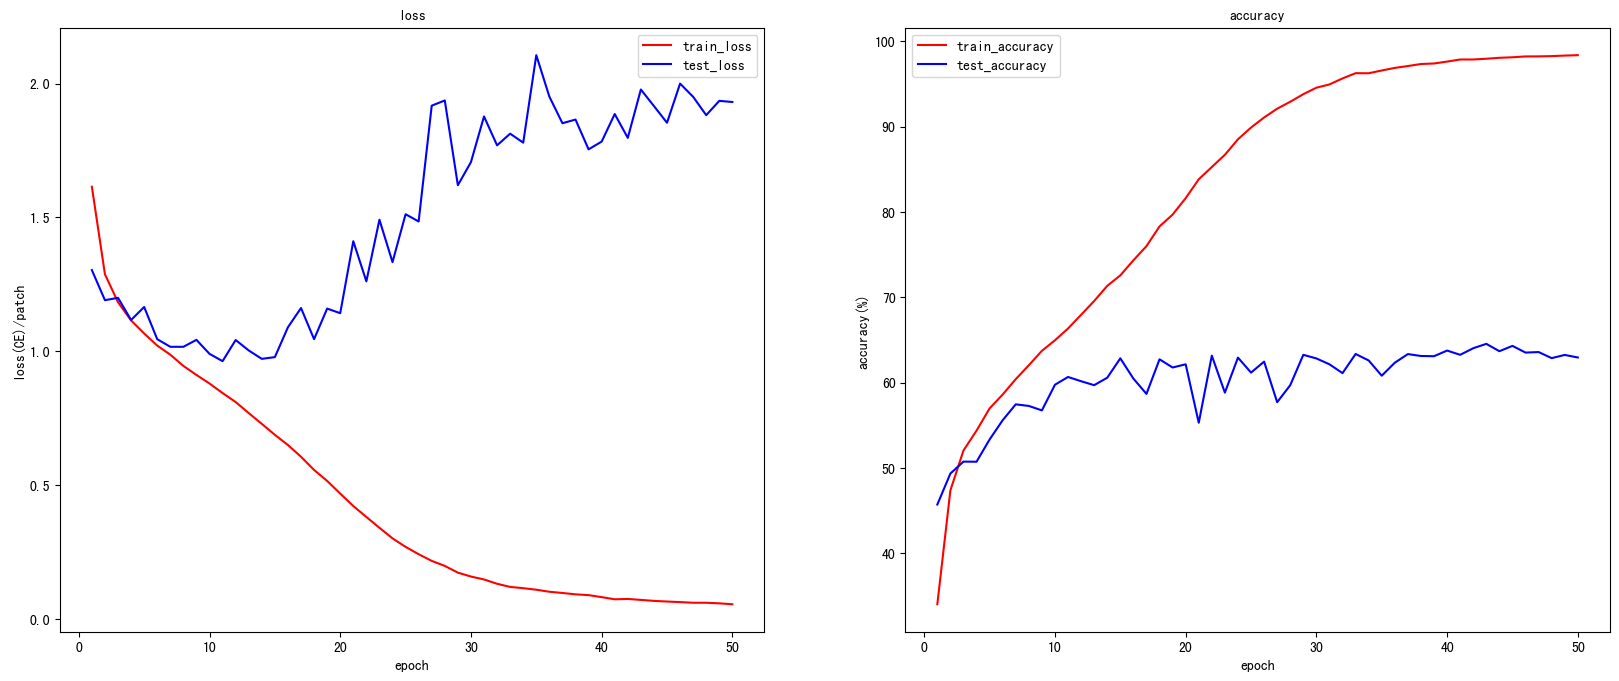

In [5]:
plot_loss_n(50)

In [6]:
test_accuracy_list.argmax()

42

In [7]:
test_accuracy_list.max()

64.55838323353294

In [8]:
test_loss_list.argmin()

10

In [10]:
for i in range(20):
    idx = i*2-1
    print("epoch: "+ str(idx+1))
    print("test_loss: "+str(test_loss_list[idx]))
    print("test_accuracy: "+str(test_accuracy_list[idx]))

epoch: 0
test_loss: 1.931194615950996
test_accuracy: 62.96157684630739
epoch: 2
test_loss: 1.190815818122404
test_accuracy: 49.36377245508982
epoch: 4
test_loss: 1.11682463974177
test_accuracy: 50.74850299401198
epoch: 6
test_loss: 1.0452009509140978
test_accuracy: 55.61377245508982
epoch: 8
test_loss: 1.0166292460914144
test_accuracy: 57.28542914171657
epoch: 10
test_loss: 0.9903046972640677
test_accuracy: 59.76796407185629
epoch: 12
test_loss: 1.04196825282585
test_accuracy: 60.17964071856287
epoch: 14
test_loss: 0.971620054465687
test_accuracy: 60.59131736526946
epoch: 16
test_loss: 1.089706238229088
test_accuracy: 60.49151696606786
epoch: 18
test_loss: 1.0451401665866256
test_accuracy: 62.749500998003995
epoch: 20
test_loss: 1.1422520038521218
test_accuracy: 62.16317365269461
epoch: 22
test_loss: 1.2611383921345938
test_accuracy: 63.17365269461078
epoch: 24
test_loss: 1.3329779288490784
test_accuracy: 62.949101796407184
epoch: 26
test_loss: 1.4848241348631919
test_accuracy: 62.4750

In [11]:
# 取第10个epoch
print(test_loss_list[9])
print(test_accuracy_list[9])

0.9903046972640677
59.76796407185629


## 统计

In [25]:
import torchmetrics

In [39]:
categories = ['disgust','fear','happy','surprise','sad','angry','neutral']
# label = 0,1,2,3,4,5,6

In [60]:
def test_metrics():
    with torch.no_grad():
        # 实例化相关metrics的计算对象
        test_f1 = torchmetrics.F1Score(average='none', num_classes=7).to(device)
        test_acc = torchmetrics.Accuracy().to(device)
        test_recall = torchmetrics.Recall(average='none', num_classes=7).to(device)
        test_precision = torchmetrics.Precision(average='none', num_classes=7).to(device)
        test_auc = torchmetrics.AUROC(average="macro", num_classes=7).to(device)
        # 开启测试阶段
        model.eval()
        for data in test_loader:
            images, labels = data
        
            # 将用来计算的张量迁移到GPU
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
             # 一个batch进行计算迭代
            test_acc(outputs.argmax(1), labels)
            test_auc.update(outputs, labels)
            test_f1.update(outputs.argmax(1), labels)
            test_recall(outputs.argmax(1), labels)
            test_precision(outputs.argmax(1), labels)

    # 计算一个epoch的accuray、recall、precision
    total_acc = test_acc.compute()
    total_recall = test_recall.compute()
    total_precision = test_precision.compute()
    total_f1 = test_f1.compute()
    total_auc = test_auc.compute()
    print("Accuracy of every class:" ,total_acc)
    print("recall of every class: ", total_recall)
    print("precision of every class: ", total_precision)
    print("f1 score of every class: ", total_f1)
    print("auc of every class: ", total_auc)
    # 清空计算对象
    test_precision.reset()
    test_acc.reset()
    test_f1.reset()
    test_recall.reset()
    test_auc.reset()

In [61]:
test_metrics()

C:\Users\Eden_\AppData\Local\Programs\Python\Python37\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Accuracy of every class: tensor(0.5977, device='cuda:0')
recall of every class:  tensor([0.5997, 0.3159, 0.6811, 0.4759, 0.5681, 0.4919, 0.9850],
       device='cuda:0')
precision of every class:  tensor([0.4939, 0.4898, 0.5864, 0.5262, 0.5279, 0.4409, 0.9322],
       device='cuda:0')
f1 score of every class:  tensor([0.5417, 0.3841, 0.6302, 0.4998, 0.5473, 0.4650, 0.9579],
       device='cuda:0')
auc of every class:  tensor(0.8448, device='cuda:0')


In [57]:
def test_categories():
    accuracy_count = [0, 0, 0, 0, 0, 0, 0]
    total_count = [0, 0, 0, 0, 0, 0, 0]
    true_positive = [0, 0, 0, 0, 0, 0, 0]
    false_positive = [0, 0, 0, 0, 0, 0, 0]
    true_negative = [0, 0, 0, 0, 0, 0, 0]
    false_negative = [0, 0, 0, 0, 0, 0, 0]
    with torch.no_grad():
        # 开启测试阶段
        model.eval()
        for data in test_loader:
            images, labels = data

            # 将用来计算的张量迁移到GPU
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            # 沿着第一个维度取最大值的下标，返回最大值、最大值下标
            _, predicted = torch.max(outputs.data, dim=1)

            # batch_size = labels.size(0)
            for i in range(labels.size(0)):
                # 记录每一类总数
                total_count[labels[i]] += 1
                # 记录每一类正确数
                if predicted[i] == labels[i]:
                    accuracy_count[predicted[i]] += 1

        for i in range(7):
            print('Accuracy on ' +
                  str(categories[i])+' is ' + format(100 * accuracy_count[i]/total_count[i], '.2f')+'%')

In [58]:
test_categories()

Accuracy on disgust is 59.97%
Accuracy on fear is 31.59%
Accuracy on happy is 68.11%
Accuracy on surprise is 47.59%
Accuracy on sad is 56.81%
Accuracy on angry is 49.19%
Accuracy on neutral is 98.50%
